<a href="https://colab.research.google.com/github/india2019-star/notebook-vault/blob/main/deep-learning/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

# __Loading and visualizing Data__

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving frey_rawface.mat to frey_rawface.mat


In [ ]:
def retrieve_device():
  device = 'cpu'
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')
  print(f"Device Found: {device}")
  return device

In [ ]:
d = retrieve_device()

Device Found: cpu


In [ ]:
frey_face_data = scipy.io.loadmat('frey_rawface.mat')['ff'].T
print(frey_face_data.shape)

(1965, 560)


In [ ]:
class CustomDataset(nn.Module):

  def __init__(self, data):
    self.data = torch.tensor(data, dtype=torch.float32) / 255.0

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    retrieved_data = self.data[idx].reshape(1, 28, 20)
    return retrieved_data

frey_dataloader = DataLoader(CustomDataset(frey_face_data), batch_size=15, shuffle=True)

Batch Feature Shape: torch.Size([15, 1, 28, 20])


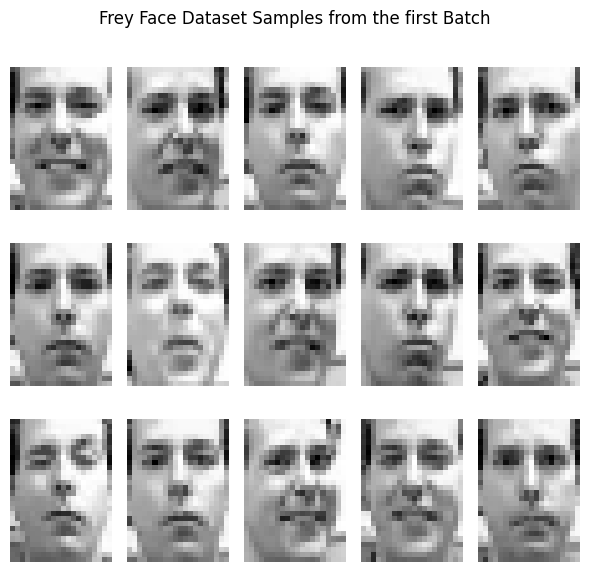

In [ ]:
for batch_features in frey_dataloader:
  print(f"Batch Feature Shape: {batch_features.shape}")
  fig, axes = plt.subplots(3, 5, figsize=(6,6))
  fig.suptitle("Frey Face Dataset Samples from the first Batch")
  axes = axes.flatten()
  for idx, feature in enumerate(batch_features):
    axes[idx].imshow(feature.squeeze(), cmap='gray')
    axes[idx].axis('off')
  plt.tight_layout()
  plt.show()
  break

# __Implementing Convolutional Variational Autoencoder__

In [36]:
class CustomVariationalAutoEncoder(nn.Module):
  def __init__(self, batch_size=15, inchannels=1, height=28, width=20, hidden_dim=30):
    super().__init__()
    self.hidden_dim = hidden_dim

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=inchannels, out_channels=32, kernel_size=3, stride=2, padding=1), #input dimensions: (15, 1, 28, 20), output dimensions: (15, 32, 14, 10)
        nn.ReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), #input dimensions: (15, 32, 14, 10), output dimensions: (15, 64, 7, 5)
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), #input dimensions: (15, 64, 7, 5), output dimensions: (15, 128, 4, 3)
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1), #input dimensions: (15, 128, 7, 5), output dimensions: (15, 256, 4, 3)
        nn.ReLU()
    )


    with torch.no_grad():
      dummy_data_for_enc_dim = torch.ones((1,inchannels,height,width))
      self.dummy_encoded_val = self.encoder(dummy_data_for_enc_dim)
      self.dummy_enc_batch, self.dummy_enc_channels, self.dummy_enc_height, self.dummy_enc_width = self.dummy_encoded_val.shape
      self.flatten_enc_shape = self.dummy_enc_channels * self.dummy_enc_height * self.dummy_enc_width

    self.linear_mu = nn.Linear(self.flatten_enc_shape, self.hidden_dim)
    self.linear_logvar = nn.Linear(self.flatten_enc_shape, self.hidden_dim)

    self.flatten_to_dec_intermediate_func = nn.Linear(self.hidden_dim, self.flatten_enc_shape)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=self.dummy_enc_channels, out_channels=self.dummy_enc_channels, kernel_size=3, stride=2, padding=1, output_padding=0), #input dimensions: (15, 256, 4, 3), output dimensions: (15, 256, 7, 5)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1), #input dimensions: (15, 256, 7, 5), output dimensions: (15, 128, 14, 10)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1), #input dimensions: (15, 128, 14, 10), output dimensions: (15, 64, 28, 20)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0, output_padding=0), #input dimensions: (15, 64, 28, 20), output dimensions: (15, 32, 28, 20)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0, output_padding=0), #input dimensions: (15, 32, 28, 20), output dimensions: (15, 1, 28, 20)
        nn.Sigmoid()
    )


  def forward(self,x):
    encoded_x = self.encoder(x)

    mu = self.linear_mu(encoded_x.flatten(1))
    logvar = self.linear_logvar(encoded_x.flatten(1))
    sigma = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(mu, device=mu.device)
    z = mu + epsilon * sigma
    flatten_to_dec_intermediate = self.flatten_to_dec_intermediate_func(z)
    # print(flatten_to_dec_intermediate.shape)
    dec = self.decoder(flatten_to_dec_intermediate.reshape(x.shape[0], self.dummy_enc_channels, self.dummy_enc_height, self.dummy_enc_width))

    # print(f"\nX shape: {x.shape}\nEncoded X shape: {encoded_x.shape}\nZ shape: {z.shape}\nMu shape: {mu.shape}\nsigma shape: {sigma.shape}\nDecoder shape: {dec.shape}\n")
    # print(f"Dummy Batch: {self.dummy_enc_batch}\nDummy Channels:{self.dummy_enc_channels}\nDummy Height: {self.dummy_enc_height}\nDummy Width: {self.dummy_enc_width}\n")
    return z, mu, logvar, dec


  def vae_loss(z, mu, logvar, dec, x,  beta = 1.0):
    batch_size, channel_size, height, width = x.shape
    rec_loss_per_image = (nn.BCELoss(reduction="sum")(dec, x)) / (batch_size * channel_size * height * width)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    kl_loss_per_image = kl_loss / (batch_size * channel_size * height * width)
    loss = rec_loss_per_image + beta * kl_loss_per_image
    # print(f"\nLoss Function Details\n=======================\nRec Loss:{rec_loss_per_image}\nKL loss Shape: {kl_loss.shape}\nKL Loss Data: {kl_loss}\nKL Loss Per Image:{kl_loss_per_image}\nTotal Loss Per Image: {loss}\n")
    return loss, kl_loss_per_image, rec_loss_per_image




In [34]:
# dummy_input_data = torch.randn(2,1,28,20)
# mm_scaler = MinMaxScaler()
# dummy_input_min_max_scaled_np = mm_scaler.fit_transform(dummy_input_data.reshape(-1, 1)).reshape(2,1,28,20)
# dummy_input_min_max_scaled = torch.from_numpy(dummy_input_min_max_scaled_np).float()
# cvAutoencoder = CustomVariationalAutoEncoder(batch_size=2, inchannels=1, height=28, width=20, hidden_dim=30)
# model_output = cvAutoencoder(dummy_input_min_max_scaled)
# vae_loss = CustomVariationalAutoEncoder.vae_loss(*model_output, dummy_input_min_max_scaled)

In [37]:
def train_vae(batch_size, inchannels, height, width, vae_model_type ='C',epoch=50):
  if vae_model_type == 'C':
    model = CustomVariationalAutoEncoder(batch_size=batch_size, inchannels=inchannels, height=height, width=width, hidden_dim=30)
  else:
    input_dim_val = inchannels * height * width
    model = LinearVAE(input_dim = input_dim_val, hidden_dim=30)
  model.to(d)
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  model.train()
  epoch_loss = []
  batch_embeddings = []
  for e in range(epoch):
    beta = min(1.0, e / (epoch // 2))
    running_loss = 0
    for batch_features in frey_dataloader:
      batch_features = batch_features.to(d)
      z, mu, logvar, dec = model(batch_features)
      loss, kl_loss_per_batch, rec_loss_per_batch = CustomVariationalAutoEncoder.vae_loss(z, mu, logvar, dec, batch_features, beta)
      running_loss += loss.item()

      batch_embeddings.append(z)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    epoch_loss.append(running_loss / len(frey_dataloader))
    print(f"Epoch: {e + 1}, Total Loss Per Batch: {loss}, KL Loss Per Batch: {kl_loss_per_batch}, Rec Loss Per Batch: {rec_loss_per_batch}")
    print("="*100)
  return model, epoch_loss, batch_embeddings

In [38]:
trained_model_vae, conv_epoch_loss, conv_batch_embeddings = train_vae(15, 1, 28, 20, 'C', 10)

Epoch: 1, Total Loss Per Batch: 0.6234531998634338, KL Loss Per Batch: 0.13139234483242035, Rec Loss Per Batch: 0.6234531998634338
Epoch: 2, Total Loss Per Batch: 0.6301474571228027, KL Loss Per Batch: 0.0069460016675293446, Rec Loss Per Batch: 0.6287582516670227
Epoch: 3, Total Loss Per Batch: 0.6247766017913818, KL Loss Per Batch: 0.004544331692159176, Rec Loss Per Batch: 0.6229588985443115
Epoch: 4, Total Loss Per Batch: 0.6190394163131714, KL Loss Per Batch: 0.006338509265333414, Rec Loss Per Batch: 0.6152362823486328
Epoch: 5, Total Loss Per Batch: 0.6181392669677734, KL Loss Per Batch: 0.006577544379979372, Rec Loss Per Batch: 0.6128772497177124
Epoch: 6, Total Loss Per Batch: 0.6243014335632324, KL Loss Per Batch: 0.004040426574647427, Rec Loss Per Batch: 0.620261013507843
Epoch: 7, Total Loss Per Batch: 0.6312577724456787, KL Loss Per Batch: 0.006487892474979162, Rec Loss Per Batch: 0.6247698664665222
Epoch: 8, Total Loss Per Batch: 0.6198055148124695, KL Loss Per Batch: 0.0050

torch.Size([15, 1, 28, 20])


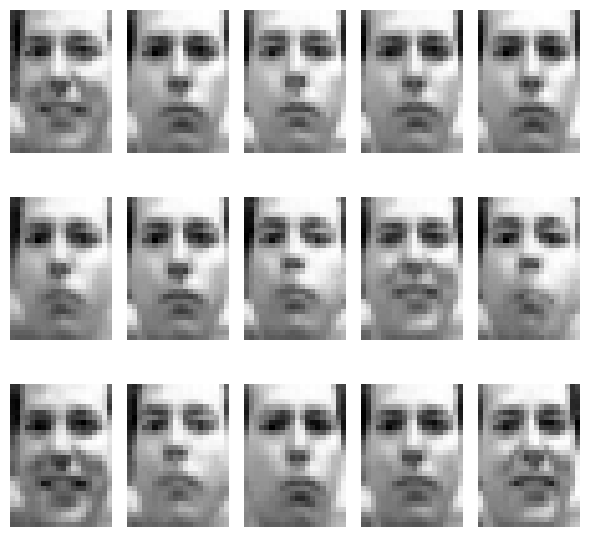

In [39]:
trained_model_vae.eval()
with torch.no_grad():
  z = torch.randn(15, trained_model_vae.hidden_dim).to(d)

  dec_input = trained_model_vae.flatten_to_dec_intermediate_func(z)
  dec_input = dec_input.reshape(15,
                                  trained_model_vae.dummy_enc_channels,
                                  trained_model_vae.dummy_enc_height,
                                  trained_model_vae.dummy_enc_width)
  gen = trained_model_vae.decoder(dec_input)
  print(gen.shape)

  fig, axes = plt.subplots(3, 5, figsize=(6,6))
  axes = axes.flatten()

  for i in range(15):
    axes[i].imshow(gen[i].to('cpu').squeeze(), cmap='gray')
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()



# __Implementing Linear VAE__

In [40]:
class LinearVAE(nn.Module):

  def __init__(self, input_dim = 560, hidden_dim = 20):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.input_dim = input_dim
    self.encoder = nn.Sequential(
        nn.Linear(self.input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32)
    )

    self.mu = nn.Linear(32, self.hidden_dim)
    self.logvar = nn.Linear(32, self.hidden_dim)


    self.decoder = nn.Sequential(
        nn.Linear(hidden_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, self.input_dim),
        nn.Sigmoid()
    )


  def forward(self, x):
    batch, channels, height, width = x.shape
    enc_x = self.encoder(x.flatten(1))
    mu = self.mu(enc_x)
    logvar = self.logvar(enc_x)

    noise = torch.torch.randn_like(mu, device=mu.device)
    sigma = torch.exp(0.5 * logvar)
    z = mu + noise * sigma
    dec = self.decoder(z)

    return z, mu, logvar, dec.reshape(batch, channels, height, width)

  def vae_loss(z, mu, logvar, dec, x, beta):
    batch_size, channels, height, width= x.shape[0]
    rec_loss_per_image = (nn.BCELoss(reduction="sum")(dec, x)) / (batch_size * channels * height * width)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    kl_loss_per_image = kl_loss / (batch_size * channels * height * width)
    loss = rec_loss_per_image + beta * kl_loss_per_image
    # print(f"\nLoss Function Details\n=======================\nRec Loss:{rec_loss_per_image}\nKL loss Shape: {kl_loss.shape}\nKL Loss Data: {kl_loss}\nKL Loss Per Image:{kl_loss_per_image}\nTotal Loss Per Image: {loss}\n")
    return loss, kl_loss_per_image, rec_loss_per_image





In [41]:
trained_linear_model_vae, linear_epoch_loss, linear_batch_embeddings = train_vae(15, 1, 28, 20,'L', 10)

Epoch: 1, Total Loss Per Batch: 0.6251038908958435, KL Loss Per Batch: 0.023695942014455795, Rec Loss Per Batch: 0.6251038908958435
Epoch: 2, Total Loss Per Batch: 0.626700758934021, KL Loss Per Batch: 9.503564797341824e-05, Rec Loss Per Batch: 0.6266817450523376
Epoch: 3, Total Loss Per Batch: 0.627921998500824, KL Loss Per Batch: 1.636997149034869e-05, Rec Loss Per Batch: 0.6279154419898987
Epoch: 4, Total Loss Per Batch: 0.627962052822113, KL Loss Per Batch: 9.503432011115365e-06, Rec Loss Per Batch: 0.6279563307762146
Epoch: 5, Total Loss Per Batch: 0.6212664842605591, KL Loss Per Batch: 2.9170334983064095e-06, Rec Loss Per Batch: 0.6212641596794128
Epoch: 6, Total Loss Per Batch: 0.6266535520553589, KL Loss Per Batch: 2.6204329515167046e-06, Rec Loss Per Batch: 0.6266509294509888
Epoch: 7, Total Loss Per Batch: 0.637274980545044, KL Loss Per Batch: 6.294743798207492e-06, Rec Loss Per Batch: 0.6372686624526978
Epoch: 8, Total Loss Per Batch: 0.6219704747200012, KL Loss Per Batch: 2

# __Inference__

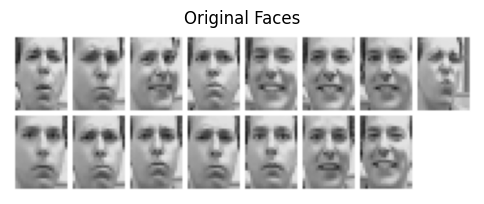

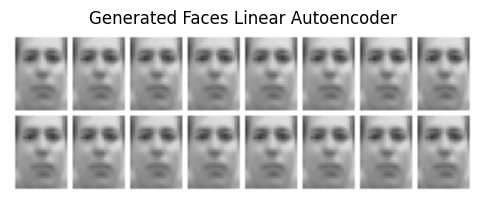

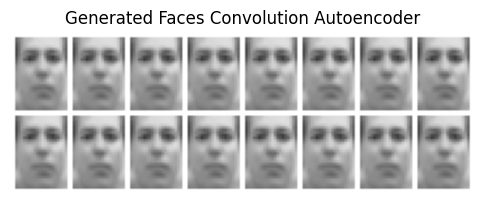

In [42]:
def show_grid(tensor_images, nrow=8, title=None):
    grid = make_grid(tensor_images, nrow=nrow, pad_value=1.0)
    plt.figure(figsize=(6,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(), cmap="gray")
    plt.axis("off")
    if title: plt.title(title)
    plt.show()




trained_linear_model_vae.eval()
trained_model_vae.eval()
with torch.no_grad():
    #Original images
    batch_features = next(iter(frey_dataloader))
    orig = batch_features.to(d)
    show_grid(orig[:16].view(-1, 1, 28, 20), nrow=8, title="Original Faces")



    #Randomly generated 16 latent vectors each of dimension 20
    z_linear = torch.randn(16, 30).to(d)
    gen = trained_linear_model_vae.decoder(z_linear)
    show_grid(gen.view(-1, 1, 28, 20), nrow=8, title="Generated Faces Linear Autoencoder")


    #Randomly generated 16 latent vectors each of dimension 20
    z_linear = torch.randn(16, trained_model_vae.hidden_dim).to(d)
    dec_input = trained_model_vae.flatten_to_dec_intermediate_func(z_linear)
    dec_input = dec_input.reshape(16,
                                  trained_model_vae.dummy_enc_channels,
                                  trained_model_vae.dummy_enc_height,
                                  trained_model_vae.dummy_enc_width)
    gen = trained_linear_model_vae.decoder(z_linear)
    show_grid(gen.view(-1, 1, 28, 20), nrow=8, title="Generated Faces Convolution Autoencoder")

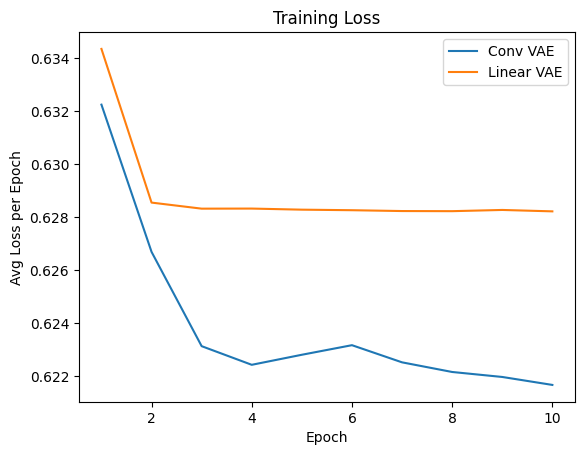

In [43]:
def check_losses():
  plt.plot(range(1, 11),  conv_epoch_loss)
  plt.plot(range(1,11), linear_epoch_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Avg Loss per Epoch')
  plt.title('Training Loss')
  plt.legend(['Conv VAE', 'Linear VAE'])
  plt.show()



check_losses()

In [44]:
len(conv_batch_embeddings)

1310

In [45]:
conv_batch_embeddings[0].shape

torch.Size([15, 30])


Shape of All Linear embddings: torch.Size([19650, 30])
Shape of All Conv embddings: torch.Size([19650, 30])
DataLoader Length: 131

Shape of All Linear embddings subset: torch.Size([5000, 30])
Shape of All Conv embddings subset: torch.Size([5000, 30])


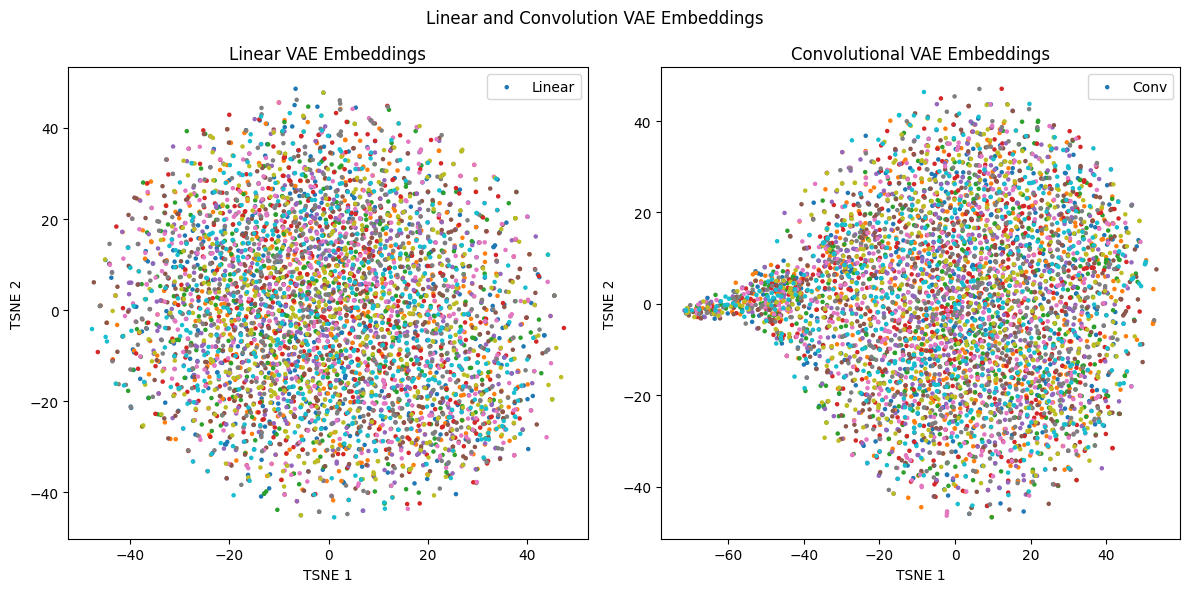

In [47]:
def visualize_embeddings(linear_embeddings, conv_embeddings, df_dataloader, n_samples=100):

  all_linear_embeddings = torch.cat(linear_embeddings, dim=0).to("cpu")
  all_conv_embeddings = torch.cat(conv_embeddings, dim=0).to("cpu")
  print(f"\nShape of All Linear embddings: {all_linear_embeddings.shape}\nShape of All Conv embddings: {all_conv_embeddings.shape}")
  dataloader_length = len(df_dataloader)
  print(f"DataLoader Length: {dataloader_length}")
  random_indices = torch.randperm(all_linear_embeddings.shape[0])[:n_samples]
  all_linear_embeddings_subset = all_linear_embeddings[random_indices]
  all_conv_embeddings_subset = all_conv_embeddings[random_indices]
  embeddings_labels = [i+1 for i in range(n_samples)]
  print(f"\nShape of All Linear embddings subset: {all_linear_embeddings_subset.shape}\nShape of All Conv embddings subset: {all_conv_embeddings_subset.shape}")
  tsne1 = TSNE(n_components=2, random_state=101)
  tsne2 = TSNE(n_components=2, random_state=101)
  linear_embd_2d = tsne1.fit_transform(all_linear_embeddings_subset.detach().numpy())
  conv_embd_2d = tsne2.fit_transform(all_conv_embeddings_subset.detach().numpy())
  fig, axes = plt.subplots(1, 2, figsize=(12,6))
  fig.suptitle("Linear and Convolution VAE Embeddings")

  axes[0].scatter(linear_embd_2d[:,0], linear_embd_2d[:,1], label='Linear',c=embeddings_labels,cmap='tab10', s=5)
  axes[0].set_title('Linear VAE Embeddings')
  axes[0].set_xlabel('TSNE 1')
  axes[0].set_ylabel('TSNE 2')
  axes[0].legend()


  axes[1].scatter(conv_embd_2d[:,0], conv_embd_2d[:,1], label='Conv',c=embeddings_labels,cmap='tab10', s=5)
  axes[1].set_title('Convolutional VAE Embeddings')
  axes[1].set_xlabel('TSNE 1')
  axes[1].set_ylabel('TSNE 2')
  axes[1].legend()

  plt.tight_layout()
  plt.show()


visualize_embeddings(linear_embeddings=linear_batch_embeddings, conv_embeddings=conv_batch_embeddings, df_dataloader=frey_dataloader, n_samples=5000)